<a href="https://colab.research.google.com/github/dakotarawlings/tool_image_classification/blob/main/Tool_image_classification_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#This notebook builds and evaluates an image classification model for a dataset of different tool classes. 
#Two CNN models are tested, one with a custom base and head and a second with a pretrained base (transfer learning)
#The moel is then saved as a JSON/h5 file

#import data pocessing tools
import numpy as np
import os
import PIL
import PIL.Image
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns
import sys


#import model building tools
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import model_from_json

In [ ]:

print(tf.__version__)

2.7.0


In [ ]:
#Verify tensorflow version and GPU connection
%tensorflow_version 2.x
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

SystemError: ignored

In [ ]:
#Establish connection with google drive directory
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#specify directories for image data

data_path="/content/gdrive/My Drive/Colab Notebooks/Tool_CV_project/tool_dataset/"

directories=['drill','hammer', 'screw_driver', 'pliers','allen_key', 'circular_saw', 'hand_saw', 'hacksaw', 'wrench', 'lug_wrench']


In [ ]:
data_dir=pathlib.Path(data_path)

In [ ]:
#Count the total number of images in the dataset
image_count=len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3158


In [ ]:
#Print randomsample images from directory:

#drill=list(data_dir.glob('drill/*'))
#PIL.Image.open(str(drill[np.random.randint(0,100)]))


In [ ]:
#Set parameters for loading training and validation sets from dataset

batch_size=32
img_height=160
img_width=160

In [ ]:
#Load images for training
train_ds=tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size 
)

Found 3158 files belonging to 10 classes.
Using 2527 files for training.


In [ ]:
#load images for validation
val_ds=tf.keras.utils.image_dataset_from_directory(
    
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height,img_width),
    batch_size=batch_size
)

Found 3158 files belonging to 10 classes.
Using 631 files for validation.


In [ ]:
#print out all of the class names
class_names=train_ds.class_names
print(class_names)

['allen_key', 'circular_saw', 'drill', 'hacksaw', 'hammer', 'hand_saw', 'lug_wrench', 'pliers', 'screw_driver', 'wrench']


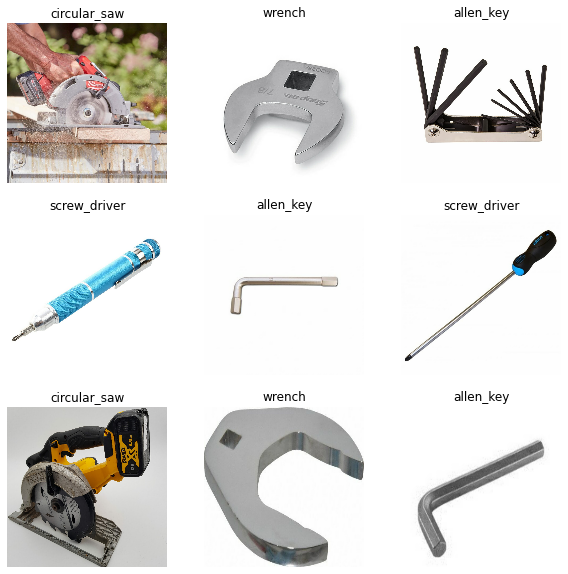

In [ ]:
#Plot a sampling of images and labels from the training dataset

import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax=plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
#print out the matrix dimenstions for each batch in the training dataset

for image_batch, labels_batch in train_ds:
  try:
    print(image_batch.shape)
    print(labels_batch.shape)
  except:
    print(image_batch)

(32, 160, 160, 3)
(32,)
(32, 160, 160, 3)
(32,)
(32, 160, 160, 3)
(32,)
(32, 160, 160, 3)
(32,)
(32, 160, 160, 3)
(32,)
(32, 160, 160, 3)
(32,)
(32, 160, 160, 3)
(32,)
(32, 160, 160, 3)
(32,)
(32, 160, 160, 3)
(32,)
(32, 160, 160, 3)
(32,)
(32, 160, 160, 3)
(32,)
(32, 160, 160, 3)
(32,)
(32, 160, 160, 3)
(32,)
(32, 160, 160, 3)
(32,)
(32, 160, 160, 3)
(32,)
(32, 160, 160, 3)
(32,)
(32, 160, 160, 3)
(32,)
(32, 160, 160, 3)
(32,)
(32, 160, 160, 3)
(32,)
(32, 160, 160, 3)
(32,)
(32, 160, 160, 3)
(32,)
(32, 160, 160, 3)
(32,)
(32, 160, 160, 3)
(32,)
(32, 160, 160, 3)
(32,)
(32, 160, 160, 3)
(32,)
(32, 160, 160, 3)
(32,)
(32, 160, 160, 3)
(32,)
(32, 160, 160, 3)
(32,)
(32, 160, 160, 3)
(32,)
(32, 160, 160, 3)
(32,)
(32, 160, 160, 3)
(32,)
(32, 160, 160, 3)
(32,)
(32, 160, 160, 3)
(32,)
(32, 160, 160, 3)
(32,)
(32, 160, 160, 3)
(32,)
(32, 160, 160, 3)
(32,)
(32, 160, 160, 3)
(32,)
(32, 160, 160, 3)
(32,)
(32, 160, 160, 3)
(32,)
(32, 160, 160, 3)
(32,)
(32, 160, 160, 3)
(32,)
(32, 160, 160, 3

In [ ]:
# get the pixel value range for an image in the dataset (roughly 0 to 255)
first_image = image_batch[0]

print(np.min(first_image), np.max(first_image))

NameError: ignored

In [ ]:
#establish a normalization layer to scale pixel values to [0,1]
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [ ]:
#optimize tf parameters based on training dataset
AUTOTUNE=tf.data.AUTOTUNE
train_ds=train_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [ ]:
#define a resizing layer and a rescaling layer to preprocess images to 160x160 with pixel values [0:1]
IMG_SIZE=160

resize_and_rescale=tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
                                        ])

In [ ]:
#Since the dataset is relatively small, we use data augmentation to increaset the size of the dataset via random flip, random rotation, and random zoom since these transformations do not change the charachteristic features necessary to identify a tool
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal_and_vertical",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [ ]:
#Define a model with 3 convolutional layers and a dense layer head

num_classes=len(class_names)

model=tf.keras.Sequential([
  #resize_and_rescale,
  data_augmentation,                      
  tf.keras.layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),  
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)

])


In [ ]:
#compile the model with the common adam optimizer, categorical sparse entropy as the loss function, and accuracy as the performance metric

model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [ ]:
#Train the model on the training data established above

epochs=15
history=model.fit(
    train_ds, 
    validation_data=val_ds,
    epochs=epochs
)

NameError: ignored

In [ ]:
#plot the model performance (accuracy and categorical cross entrolpy) on the training and validation datasets as a funcion of epoch

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

NameError: ignored

In [ ]:
# We now build a model using transfer learning, where we utilize the MobileNetV2 pretrained convolutional base

BATCH_SIZE=32
IMG_SIZE=(160, 160)

In [ ]:
#Load images for training
train_ds=tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE 
)

Found 3158 files belonging to 10 classes.
Using 2527 files for training.


In [ ]:
#load images for validation
val_ds=tf.keras.utils.image_dataset_from_directory(
    
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE 
)

Found 3158 files belonging to 10 classes.
Using 631 files for validation.


In [ ]:
AUTOTUNE=tf.data.AUTOTUNE

train_dataset=train_ds.prefetch(buffer_size=AUTOTUNE)
validation_dataset=val_ds.prefetch(buffer_size=AUTOTUNE)


In [ ]:
# Use the predefined preprocessing functions for the mobilenet_v2

preprocess_input=tf.keras.applications.mobilenet_v2.preprocess_input

#the mobile net model expects pixel values [-1, 1]
rescale=tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [ ]:
# Define the pretrained MobileNeeV2 model as our pretrained base and set it so that the base is not trained when we train our model

IMG_SHAPE=IMG_SIZE+(3,)
base_model=tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, 
                                             include_top=False,
                                             weights='imagenet')

image_batch, lael_batch=next(iter(train_ds))
feature_batch=base_model(image_batch)
print(feature_batch.shape)

base_model.trainable=False

(32, 5, 5, 1280)


In [ ]:
# Inspect the model parameters and infrastructure
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [ ]:
#Establish our global average pooling layer for our head
global_average_layer=tf.keras.layers.GlobalAveragePooling2D()

feature_batch_average=global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
#Define the final dense layer of our head

prediction_layer=tf.keras.layers.Dense(10)

prediction_batch=prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 10)


In [ ]:
##define our model with preprocessing and convolutional layers as our inputs and our dense layer for classification as our output
inputs=tf.keras.Input(shape=(160, 160, 3))
x=data_augmentation(inputs)
x=preprocess_input(x)
x=base_model(x, training=False)
x=global_average_layer(x)
x=tf.keras.layers.Dropout(0.2)(x)
outputs=prediction_layer(x)

model=tf.keras.Model(inputs, outputs)

In [ ]:
#Compile our model with the adam optimizer, sparse categorical entropy as our loss function, and accuracy as our performance metric
base_learning_rate=0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
#Review the parameters and structure of our model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [ ]:
#get a baseline accuracy for the model before t is trained
initial_epochs=20

loss0, accuracy0=model.evaluate(val_ds)

20/20 [==============================] - 66s 2s/step - loss: 3.3586 - accuracy: 0.0412


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 3.36
initial accuracy: 0.04


In [ ]:
#Fit the model to the training data
history=model.fit(train_ds, epochs=initial_epochs, validation_data=val_ds)

Epoch 1/20
79/79 [==============================] - 89s 1s/step - loss: 2.6161 - accuracy: 0.1334 - val_loss: 2.0427 - val_accuracy: 0.2742
Epoch 2/20
79/79 [==============================] - 83s 1s/step - loss: 1.8795 - accuracy: 0.3708 - val_loss: 1.5138 - val_accuracy: 0.5246
Epoch 3/20
79/79 [==============================] - 89s 1s/step - loss: 1.4803 - accuracy: 0.5295 - val_loss: 1.1945 - val_accuracy: 0.6545
Epoch 4/20
79/79 [==============================] - 87s 1s/step - loss: 1.2329 - accuracy: 0.6296 - val_loss: 0.9879 - val_accuracy: 0.7258
Epoch 5/20
79/79 [==============================] - 89s 1s/step - loss: 1.0534 - accuracy: 0.6803 - val_loss: 0.8415 - val_accuracy: 0.7670
Epoch 6/20
79/79 [==============================] - 91s 1s/step - loss: 0.9290 - accuracy: 0.7420 - val_loss: 0.7399 - val_accuracy: 0.7971
Epoch 7/20
79/79 [==============================] - 90s 1s/step - loss: 0.8261 - accuracy: 0.7661 - val_loss: 0.6571 - val_accuracy: 0.8257
Epoch 8/20
79/79 [==

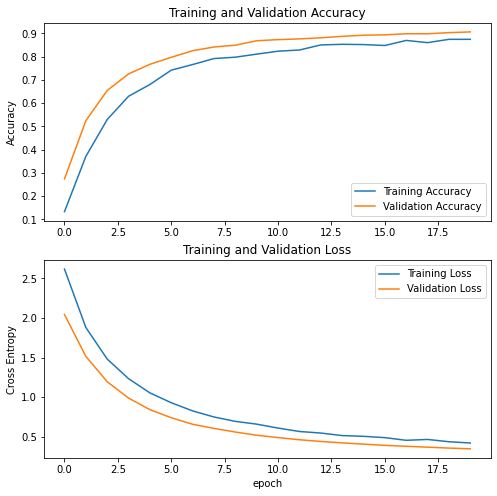

In [ ]:
#Plot the performance of the model on training and validation datasets as a function of teh epoch

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
#plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
#plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
#Test the model with a random picure from a class
drill=list(data_dir.glob('drill/*'))
drill_path=str(drill[np.random.randint(0,100)])
PIL.Image.open(drill_path)
img=tf.keras.utils.load_img(drill_path, target_size=(img_height, img_width))

img_array=tf.keras.utils.img_to_array(img)
img_array=tf.expand_dims(img_array, 0)

predictions=model.predict(img_array)
score=tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100*np.max(score))

)


This image most likely belongs to drill with a 91.48 percent confidence.


In [ ]:
#save the model structure and the model weights so that it can be used in an app/api
model_json=model.to_json()
with open("model.json", "w") as json_file:
  json_file.write(model_json)
model.save_weights("model.h5")

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
#Open the model that we saved 
json_file=open('/content/gdrive/My Drive/Colab Notebooks/Tool_CV_project/model/model.json','r')
loaded_model_json=json_file.read()
json_file.close()
loaded_model=model_from_json(loaded_model_json)
loaded_model.load_weights("/content/gdrive/My Drive/Colab Notebooks/Tool_CV_project/model/model.h5")
loaded_model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'] )
    

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = val_ds.as_numpy_iterator().next()

#Use the model to predict classes for each image
predictions = loaded_model.predict_on_batch(image_batch)

#Transform the predictions to classes
predictions = [np.argmax(tf.nn.softmax(prediction)) for prediction in predictions]

print('Predictions:\n', predictions)
print('Labels:\n', label_batch)

#Make a confusion matrix with predictions and true values
conmat=tf.math.confusion_matrix(
    label_batch, predictions, num_classes=None, weights=None, dtype=tf.dtypes.int32,
    name=None
)



Predictions:
 [0, 0, 4, 3, 1, 0, 2, 7, 8, 7, 4, 8, 4, 9, 5, 4, 2, 8, 9, 7, 4, 9, 7, 1, 6, 1, 7, 8, 5, 4, 9, 1]
Labels:
 [0 0 4 3 1 0 2 7 8 7 4 0 4 9 5 4 2 8 0 7 4 9 7 1 6 1 7 8 0 4 9 1]


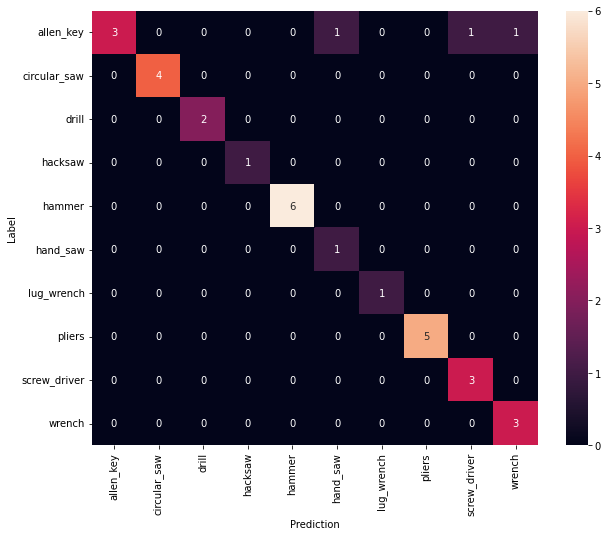

In [ ]:
#plot the confusion matrix as a heatmap
def show_confusion_matrix(cm, labels):
  plt.figure(figsize=(10, 8))
  sns.heatmap(cm, xticklabels=labels, yticklabels=labels, 
              annot=True, fmt='g')
  plt.xlabel('Prediction')
  plt.ylabel('Label')
  plt.show()

show_confusion_matrix(conmat, class_names)